In [1]:
import os
import time
import copy
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
!unzip -q "/content/MetdataDataset.zip" -d /content/dataset

In [3]:
#
train_images_folder = '/content/dataset/MetdataDataset/Doctor’s Handwritten Prescription BD dataset/Training/training_words'
val_images_folder   = '/content/dataset/MetdataDataset/Doctor’s Handwritten Prescription BD dataset/Validation/validation_words'
test_images_folder  = '/content/dataset/MetdataDataset/Doctor’s Handwritten Prescription BD dataset/Testing/testing_words'

train_label_file = '/content/dataset/MetdataDataset/Doctor’s Handwritten Prescription BD dataset/Training/training_labels_updated.csv'
val_label_file   = '/content/dataset/MetdataDataset/Doctor’s Handwritten Prescription BD dataset/Validation/validation_labels_updated.csv'
test_label_file  = '/content/dataset/MetdataDataset/Doctor’s Handwritten Prescription BD dataset/Testing/testing_labels_updated.csv'


metadata_columns = [
    'drug_category',
    'dosage_form',
    'otc_status',

]

target_col = 'MEDICINE_NAME'


In [13]:
import pandas as pd
import os

def check_master_leakage(train_file, val_file, test_file,
                         train_img_dir, val_img_dir, test_img_dir,
                         metadata_columns, target_col="MEDICINE_NAME"):
    # Load CSVs
    train_df = pd.read_csv(train_file)
    val_df   = pd.read_csv(val_file)
    test_df  = pd.read_csv(test_file)
    metadata_leakage = {}
    for col in metadata_columns:
        mapping = train_df.groupby(col)[target_col].nunique()
        unique_leak = mapping[mapping == 1]
        metadata_leakage[col] = len(unique_leak)

    return train_df, val_df, test_df, overlap_results, metadata_leakage


In [14]:
train_df, val_df, test_df, overlap_results, metadata_leakage = check_master_leakage(
    train_label_file,
    val_label_file,
    test_label_file,
    train_images_folder,
    val_images_folder,
    test_images_folder,
    metadata_columns,
    target_col="MEDICINE_NAME"
)

print("Metadata Leakage:", metadata_leakage)



Metadata Leakage: {'drug_category': 1, 'dosage_form': 2, 'otc_status': 0}


In [15]:
def remove_rare_leaks(df, metadata_columns, target_col):

    df_clean = df.copy()
    for col in metadata_columns:
        counts = df.groupby(col)[target_col].nunique()
        rare_values = counts[counts == 1].index
        df_clean.loc[df_clean[col].isin(rare_values), col] = None
    return df_clean


In [16]:
train_df_clean = remove_rare_leaks(train_df, metadata_columns, target_col)
val_df_clean   = remove_rare_leaks(val_df, metadata_columns, target_col)
test_df_clean  = remove_rare_leaks(test_df, metadata_columns, target_col)


In [17]:
def verify_metadata_leakage(df, metadata_columns, target_col):
    leakage_info = {}
    for col in metadata_columns:
        counts = df.groupby(col)[target_col].nunique()
        leakage_info[col] = len(counts[counts == 1])
    return leakage_info

metadata_leak_check_train = verify_metadata_leakage(train_df_clean, metadata_columns, target_col)
print("Metadata leakage after cleaning:", metadata_leak_check_train)



Metadata leakage after cleaning: {'drug_category': 0, 'dosage_form': 0, 'otc_status': 0}


In [18]:
df_train = pd.read_csv(train_label_file)
df_val = pd.read_csv(val_label_file)
df_test = pd.read_csv(test_label_file)

for df in [df_train, df_val, df_test]:
    df.columns = df.columns.str.strip()

encoders = {}
for col in metadata_columns + [target_col]:
    le = LabelEncoder()
    le.fit(df_train[col])
    encoders[col] = le
    df_train[col] = le.transform(df_train[col])
    df_val[col] = le.transform(df_val[col])
    df_test[col] = le.transform(df_test[col])

num_classes = len(encoders[target_col].classes_)
metadata_cardinalities = [len(encoders[col].classes_) for col in metadata_columns]

print(f"Num classes: {num_classes}")
print(f"Metadata cardinalities: {metadata_cardinalities}")


Num classes: 78
Metadata cardinalities: [13, 5, 3]


In [19]:
class PrescriptionDataset(Dataset):
    def __init__(self, images_folder, df, metadata_cols, target_col, transform=None):
        self.images_folder = images_folder
        self.df = df
        self.metadata_cols = metadata_cols
        self.target_col = target_col
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.images_folder, row['IMAGE'])
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(image=np.array(img))['image']

        meta_features = torch.tensor([row[col] for col in self.metadata_cols], dtype=torch.long)
        label = torch.tensor(row[self.target_col], dtype=torch.long)
        return img, meta_features, label


In [20]:
train_transform = A.Compose([
    A.Resize(224, 224),
    A.Rotate(limit=15, p=0.7),
    A.Affine(translate_percent=0.05, scale=(0.9, 1.1), rotate=0, shear=0, p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussNoise(p=0.4),
    A.OneOf([
        A.MotionBlur(blur_limit=3, p=1.0),
        A.MedianBlur(blur_limit=3, p=1.0),
        A.Blur(blur_limit=3, p=1.0),
    ], p=0.3),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [21]:
batch_size = 6
num_workers = 2

train_ds = PrescriptionDataset(train_images_folder, df_train, metadata_columns, target_col, transform=train_transform)
val_ds = PrescriptionDataset(val_images_folder, df_val, metadata_columns, target_col, transform=val_test_transform)
test_ds = PrescriptionDataset(test_images_folder, df_test, metadata_columns, target_col, transform=val_test_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f"Train/Val/Test sizes: {len(train_ds)}, {len(val_ds)}, {len(test_ds)}")


Train/Val/Test sizes: 3120, 780, 780


In [22]:
class MultiModalModel(nn.Module):
    def __init__(self, num_classes, metadata_cardinalities, embed_dim=16):
        super().__init__()
        base_model = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1)
        self.cnn = base_model.features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.flatten = nn.Flatten()
        self.cnn_fc = nn.Sequential(
            nn.Linear(512 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.metadata_embeds = nn.ModuleList(
            [nn.Embedding(cardinality, embed_dim) for cardinality in metadata_cardinalities]
        )

        self.fc = nn.Sequential(
            nn.Linear(512 + embed_dim * len(metadata_cardinalities), 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x_img, x_meta):
        x_img = self.cnn(x_img)
        x_img = self.avgpool(x_img)
        x_img = self.flatten(x_img)
        x_img = self.cnn_fc(x_img)

        meta_embeds = [embed(x_meta[:, i]) for i, embed in enumerate(self.metadata_embeds)]
        x_meta = torch.cat(meta_embeds, dim=1)

        x = torch.cat([x_img, x_meta], dim=1)
        out = self.fc(x)
        return out

In [23]:
def train_validate(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=36, save_path='best_multimodal.pth', patience=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    early_stop_counter = 0

    for epoch in range(num_epochs):
        # ---- Train ----
        model.train()
        running_loss, running_corrects, total = 0, 0, 0
        for imgs, metas, labels in train_loader:
            imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs, metas)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * imgs.size(0)
            running_corrects += torch.sum(preds == labels).item()
            total += imgs.size(0)

        train_loss = running_loss / total
        train_acc = running_corrects / total


        model.eval()
        val_running_loss, val_running_corrects, val_total = 0, 0, 0
        with torch.no_grad():
            for imgs, metas, labels in val_loader:
                imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
                outputs = model(imgs, metas)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_running_loss += loss.item() * imgs.size(0)
                val_running_corrects += torch.sum(preds == labels).item()
                val_total += imgs.size(0)

        val_loss = val_running_loss / val_total
        val_acc = val_running_corrects / val_total


        if scheduler is not None:
            scheduler.step(val_loss)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | Train loss: {train_loss:.4f} acc: {train_acc:.4f} | Val loss: {val_loss:.4f} acc: {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), save_path)
            early_stop_counter = 0
            print("  Saved best model.")
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s | Best val Acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title("Loss Curve")
    plt.subplot(1,2,2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.legend()
    plt.title("Accuracy Curve")
    plt.show()

    return model, history

In [24]:
def evaluate_and_report_avg(model, loader, id_to_label):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, metas, labels in loader:
            imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
            outputs = model(imgs, metas)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy: {acc:.4f}")
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    avg_metrics = {
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1-score': report['weighted avg']['f1-score'],
        'accuracy': report['accuracy']
    }
    print("Average Metrics (weighted):", avg_metrics)
    return avg_metrics

In [26]:
model = MultiModalModel(num_classes=num_classes, metadata_cardinalities=metadata_cardinalities).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3
)



Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


100%|██████████| 528M/528M [00:06<00:00, 80.7MB/s]


Epoch 1/30 | Train loss: 4.2886 acc: 0.0359 | Val loss: 4.0187 acc: 0.1705
  Saved best model.
Epoch 2/30 | Train loss: 3.6899 acc: 0.1593 | Val loss: 2.1006 acc: 0.6205
  Saved best model.
Epoch 3/30 | Train loss: 2.4365 acc: 0.4038 | Val loss: 0.9960 acc: 0.8449
  Saved best model.
Epoch 4/30 | Train loss: 1.5354 acc: 0.6090 | Val loss: 0.5482 acc: 0.9128
  Saved best model.
Epoch 5/30 | Train loss: 1.0730 acc: 0.7224 | Val loss: 0.3520 acc: 0.9385
  Saved best model.
Epoch 6/30 | Train loss: 0.8043 acc: 0.8067 | Val loss: 0.2966 acc: 0.9397
  Saved best model.
Epoch 7/30 | Train loss: 0.5598 acc: 0.8583 | Val loss: 0.2561 acc: 0.9385
Epoch 8/30 | Train loss: 0.4395 acc: 0.8872 | Val loss: 0.2227 acc: 0.9538
  Saved best model.
Epoch 9/30 | Train loss: 0.3363 acc: 0.9208 | Val loss: 0.2047 acc: 0.9551
  Saved best model.
Epoch 10/30 | Train loss: 0.2879 acc: 0.9314 | Val loss: 0.1726 acc: 0.9564
  Saved best model.
Epoch 11/30 | Train loss: 0.2382 acc: 0.9439 | Val loss: 0.1728 acc: 

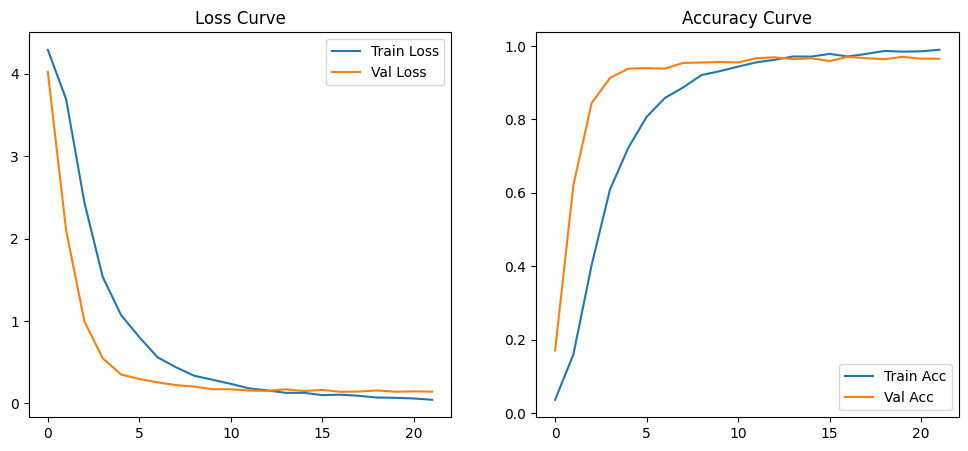

In [27]:
model, history = train_validate(model, train_loader, val_loader, criterion, optimizer, scheduler=scheduler, num_epochs=30)


In [28]:
id_to_label = {i:c for i,c in enumerate(encoders[target_col].classes_)}
_ = evaluate_and_report_avg(model, test_loader, id_to_label)


Test Accuracy: 0.9269
Average Metrics (weighted): {'precision': 0.9371175832714296, 'recall': 0.926923076923077, 'f1-score': 0.9247126662779458, 'accuracy': 0.926923076923077}


In [29]:
import shap

# Model in eval mode
model.eval()
background_meta = torch.stack(
    [test_ds[i][1] for i in range(min(50, len(test_ds)))],
    dim=0
).long().to(device)
def f_tabular(meta_input, class_idx=0):
    with torch.no_grad():
        meta_input = torch.tensor(meta_input, dtype=torch.long).to(device)
        batch_size = meta_input.shape[0]
        cnn_features = torch.zeros(batch_size, 512).to(device)
        meta_embeds = [model.metadata_embeds[i](meta_input[:, i]) for i in range(len(metadata_columns))]
        meta_embeds = torch.cat(meta_embeds, dim=1)
        x = torch.cat([cnn_features, meta_embeds], dim=1)
        out = model.fc(x)
        probs = torch.softmax(out, dim=1)
        return probs[:, class_idx].cpu().numpy()

explainer = shap.KernelExplainer(
    lambda x: f_tabular(x, class_idx=0),
    background_meta.cpu().numpy()
)
test_meta_samples = torch.stack([test_ds[i][1] for i in range(5)], dim=0).long().to(device)
test_meta_samples_np = test_meta_samples.cpu().numpy()
shap_values = explainer.shap_values(test_meta_samples_np)

  0%|          | 0/5 [00:00<?, ?it/s]

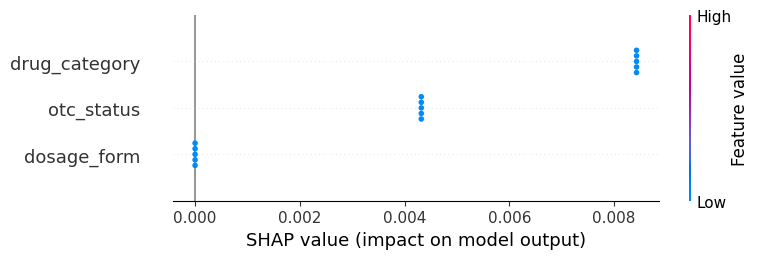

In [30]:
shap.summary_plot(
    shap_values,
    test_meta_samples_np,
    feature_names=metadata_columns
)

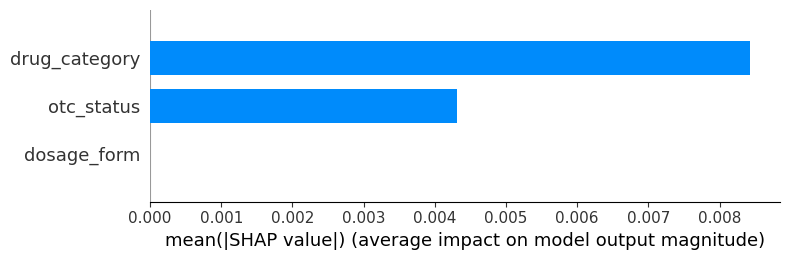

In [31]:
# 2) Summary plot (bar)
shap.summary_plot(
    shap_values,
    test_meta_samples_np,
    feature_names=metadata_columns,
    plot_type='bar'
)

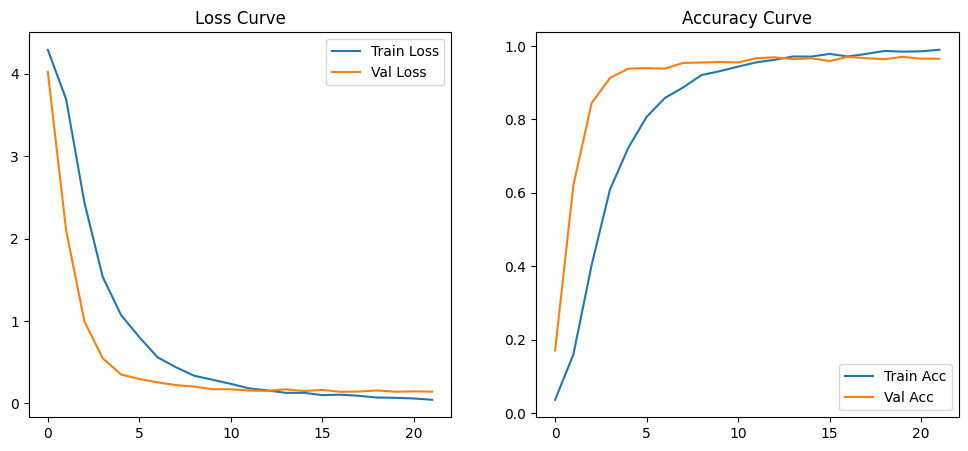

In [32]:
# ---- Plot and save loss/accuracy curves ----
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.savefig('loss_curve.png')   # Save figure
plt.subplot(1,2,2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.legend()
plt.title("Accuracy Curve")
plt.savefig('accuracy_curve.png')  # Save figure
plt.show()


Plots saved: loss_curve.png, accuracy_curve.png, shap_dot_plot.png, shap_bar_plot.png


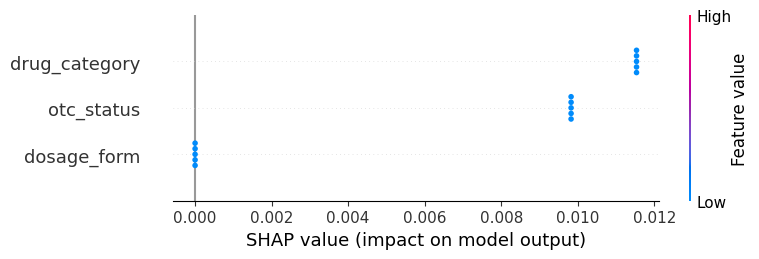

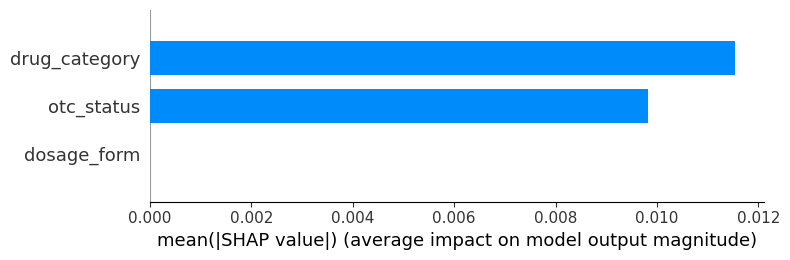

In [ ]:
import shap


plt.figure()
shap.summary_plot(
    shap_values,
    test_meta_samples_np,
    feature_names=metadata_columns,
    show=False
)
plt.savefig('shap_dot_plot.png', bbox_inches='tight')
plt.figure()
shap.summary_plot(
    shap_values,
    test_meta_samples_np,
    feature_names=metadata_columns,
    plot_type='bar',
    show=False
)
plt.savefig('shap_bar_plot.png', bbox_inches='tight')

print("Plots saved: loss_curve.png, accuracy_curve.png, shap_dot_plot.png, shap_bar_plot.png")


In [ ]:
from google.colab import files

files.download('loss_curve.png')
files.download('accuracy_curve.png')
files.download('shap_dot_plot.png')
files.download('shap_bar_plot.png')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>